In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed, GRU
from tensorflow.keras.regularizers import L1L2

In [9]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y



In [13]:
import numpy as np
X_test = np.load("/content/drive/MyDrive/project/project_data/X_test.npy")
y_test = np.load("/content/drive/MyDrive/project/project_data/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/project/project_data/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/project/project_data/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/project/project_data/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/project/project_data/person_test.npy")



y_train_valid -= 769
y_test -= 769

In [14]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)




## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (1772, 4)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width info: (1772, 22, 250, 1)
Shape of training set af

In [26]:
from keras.layers.advanced_activations import LeakyReLU
model = Sequential()

# Conv. block 1
model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
model.add(MaxPooling2D(pool_size=(3,1), padding='same')) 

model.add(BatchNormalization())
model.add(ELU())
model.add(Dropout(0.3))

# Conv. block 2
model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
# model.add(MaxPooling2D(pool_size=(3,1), padding='same'))

model.add(BatchNormalization())
model.add(ELU())
model.add(Dropout(0.3))

# Conv. block 3
model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
# model.add(MaxPooling2D(pool_size=(3,1), padding='same'))

model.add(BatchNormalization())
model.add(ELU())
model.add(Dropout(0.3))


model.add((Flatten())) # Adding a flattening operation 
model.add(Dense((100)))

# Output layer with Softmax activation 
model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 84, 1, 25)        0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 84, 1, 25)        100       
 hNormalization)                                                 
                                                                 
 elu_6 (ELU)                 (None, 84, 1, 25)         0         
                                                                 
 dropout_6 (Dropout)         (None, 84, 1, 25)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 84, 1, 50)        

In [27]:
from keras.layers import Dense, Activation, Flatten,Dropout
from tensorflow.keras.optimizers import Adam
# Model parameters
learning_rate = 1e-3
epochs = 50
opt = Adam(lr=learning_rate)

# Compiling the model
model.compile(loss='categorical_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


109/109 [==============================] - 14s 120ms/step - loss: 3.1747 - accuracy: 0.4250 - val_loss: 1.5105 - val_accuracy: 0.5373
Epoch 2/50
109/109 [==============================] - 13s 117ms/step - loss: 1.3156 - accuracy: 0.5700 - val_loss: 0.7607 - val_accuracy: 0.6960
Epoch 3/50
109/109 [==============================] - 16s 146ms/step - loss: 0.8532 - accuracy: 0.6593 - val_loss: 0.6148 - val_accuracy: 0.7887
Epoch 4/50
109/109 [==============================] - 13s 118ms/step - loss: 0.7282 - accuracy: 0.7243 - val_loss: 0.5577 - val_accuracy: 0.7987
Epoch 5/50
109/109 [==============================] - 14s 124ms/step - loss: 0.6533 - accuracy: 0.7549 - val_loss: 0.5186 - val_accuracy: 0.8100
Epoch 6/50
109/109 [==============================] - 17s 153ms/step - loss: 0.6027 - accuracy: 0.7749 - val_loss: 0.4510 - val_accuracy: 0.8440
Epoch 7/50
109/109 [==============================] - 18s 163ms/step - loss: 0.5629 - accuracy: 0.7899 - val_loss: 0.4027 - val_accuracy: 0.8

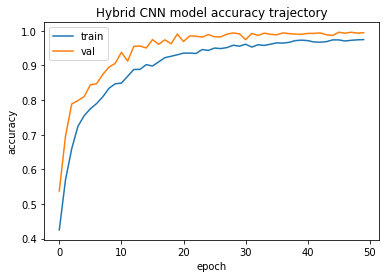

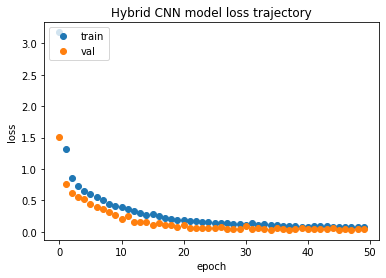

In [30]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.6563205122947693
